# Importing Modules

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import math
from osgeo import gdal,gdal_array
from sklearn.decomposition import PCA


DATA_PATH = 'Dataset_963A/'

In [22]:
def save_img2Geotiff(img,filename):
    r,c = img.shape
    pr_d = gdal.Open(DATA_PATH+'LandMasked_Amplitude_VV.tif')
    driver = gdal.GetDriverByName("GTiff")
    outdata = driver.Create(filename, r, c, 1, gdal.GDT_Float32)
    outdata.SetGeoTransform(pr_d.GetGeoTransform())##sets same geotransform as input
    outdata.SetProjection(pr_d.GetProjection())##sets same projection as input
    outdata.GetRasterBand(1).WriteArray(img)
    print("Image Saved Succesfully.")

def find_threshold(data,components):
    s_pca = PCA(n_components=components)
    for_s_pca = s_pca.fit_transform(data)
    #plt.imshow(for_s_pca,cmap='gray')
    #Image.fromarray(for_s_pca).show()

    max_v = for_s_pca[:,0]
    min_v = for_s_pca[:,(components-1)]
    threshold = (max_v.std() + min_v.std())/2
    #print(threshold)

    inv_s_pca = s_pca.inverse_transform(for_s_pca)
    #plt.imshow(inv_s_pca,cmap='gray',vmin=0,vmax=255)
    #plt.imsave('PrincipalComponentImage.tiff',inv_s_pca,cmap='gray')
    return (inv_s_pca,threshold)


def getDetectedShip(img,threshold):
    rows,cols = img.shape
    ship_p = []
    nonShip_p = []
    temp = img.reshape(rows*cols,1)

    for d in range(len(temp)):
        if temp[d] < threshold:
            #nonShip_p.append(temp[d])
            temp[d] = 0
        else:
            #ship_p.append(temp[d])
            temp[d] = 1

    fin_img = temp.reshape(rows,cols)
    #plt.imshow(fin_img,cmap='gray')
    #plt.imsave('Output_fromPCA.tiff',fin_img,cmap='gray')
    return (fin_img,ship_p,nonShip_p)

def readGeoTiff(img):
    # Importing Product and getting data from the band
    product = gdal_array.LoadFile(img)
    product = np.array(product)
    return product

def subsetImg(img,row,col):
    #Comuting subset of the image for demo processing
    subset_min_size = row
    subset_max_size = col
    size = subset_max_size - subset_min_size
    subset_data = img[subset_min_size:subset_max_size,subset_min_size:subset_max_size]
    subset_data = np.array(subset_data)
    #plt.imsave('Input_Image.tiff',subset_data,cmap='gray')
    #print(subset_data.shape)
    
    return subset_data
   

def visualizeImg(img):
    plt.imshow(img,cmap='gray',vmin=0,vmax=255)

10201 10596


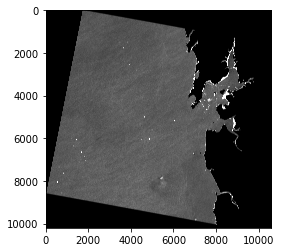

In [23]:
#Computing rows and columns
band_data_arr = readGeoTiff(DATA_PATH+'LandMasked_Amplitude_VV.tif')
rows,col = band_data_arr.shape
print(rows,col)
visualizeImg(band_data_arr)

Image Saved Succesfully.


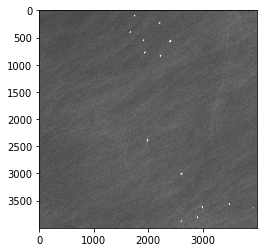

In [24]:
subset_img = subsetImg(band_data_arr,2000,6000)
visualizeImg(subset_img)
save_img2Geotiff(subset_img,DATA_PATH+'Input.tif')

In [39]:
computed_threshold = []

for i in range(1,2001,10):
    print("Working on Component: "+str(i)+"\n")
    pca_img,threshold = find_threshold(subset_img,i)
    computed_threshold.append(threshold)
    bin_ships = getDetectedShip(pca_img,threshold)
    save_img2Geotiff(bin_ships,'Dataset_963A/ShipDetectedOutputsImg/Output_C'+str(i)+'.tif')
    print("Task for componenet: "+str(i)+" is completed.\nThreshold recieved is: "+str(threshold)+"\n")

In [40]:
#diff = []
#for i in range(len(computed_threshold)):
#    if (i+1) == len(computed_threshold):
#        pass
#    else:
#        diff.append(computed_threshold[i]-computed_threshold[i+1])

In [41]:
#plt.plot([int(i) for i in range(len(diff))],diff)